In [1]:
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models
import cv2
from PIL import Image
from pdb import set_trace
import time
import copy
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
#from skimage import io, transform
from tqdm import trange, tqdm
import csv
import glob
import dlib
import pandas as pd
import numpy as np
from models.inception_resnet_v1 import InceptionResnetV1
import faceBlendCommon as fbc

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
device

device(type='cuda')

In [4]:
def align_image():
    data_dir = 'data/test_me'
    for train_test in ['train','val']:
        train_test_path=os.path.join(data_dir,train_test)
        for person_folder in os.listdir(train_test_path):
            folder_path=os.path.join(train_test_path,person_folder)
            for each_file in os.listdir(folder_path):
                align_and_save(os.path.join(folder_path,each_file))

In [5]:
def align_and_save(file):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    print(file)
    im=cv2.imread(file)
    faceRects=detector(im,0)
    
    points = fbc.getLandmarks(detector, predictor, im)
    points=np.array(points)
    im = np.float32(im)/255.0
    
    h=600
    w=600
    imNorm, points = fbc.normalizeImagesAndLandmarks((h,w), im, points)
    imNorm = np.uint8(imNorm*255)
    cv2.imwrite(file,imNorm)

In [6]:
align_image()

data/test_me\train\amrish-puri\amrish-puri1.jpg
data/test_me\train\amrish-puri\amrish-puri10.jpg
data/test_me\train\amrish-puri\amrish-puri2.jpg
data/test_me\train\amrish-puri\amrish-puri3.jpg
data/test_me\train\amrish-puri\amrish-puri4.jpg
data/test_me\train\amrish-puri\amrish-puri5.jpg
data/test_me\train\amrish-puri\amrish-puri6.jpg
data/test_me\train\amrish-puri\amrish-puri7.jpg
data/test_me\train\amrish-puri\amrish-puri8.jpg
data/test_me\train\amrish-puri\amrish-puri9.jpg
data/test_me\train\Dhoni\Dhoni1.jpg
data/test_me\train\Dhoni\Dhoni10.jpg
data/test_me\train\Dhoni\Dhoni2.jpg
data/test_me\train\Dhoni\Dhoni3.jpg
data/test_me\train\Dhoni\Dhoni4.jpg
data/test_me\train\Dhoni\Dhoni5.jpg
data/test_me\train\Dhoni\Dhoni6.jpg
data/test_me\train\Dhoni\Dhoni7.jpg
data/test_me\train\Dhoni\Dhoni8.jpg
data/test_me\train\Dhoni\Dhoni9.jpg
data/test_me\train\irrfan-khan\Irrfan_Khan1.jpg
data/test_me\train\irrfan-khan\Irrfan_Khan10.jpg
data/test_me\train\irrfan-khan\Irrfan_Khan2.jpg
data/test_me\

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((160,160)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((160,160)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = 'data/test_me'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=10, 
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
class_names

['Dhoni',
 'amrish-puri',
 'irrfan-khan',
 'mahatma-gandhi',
 'narendra-modi',
 'nitish-kumar',
 'rahul-gandhi',
 'ratan_tata',
 'sachin',
 'shahrukh']

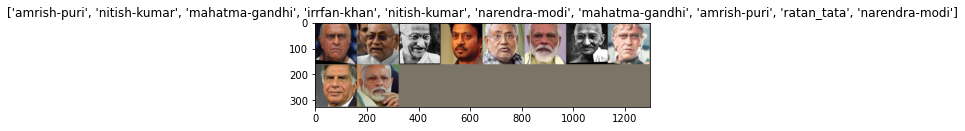

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [9]:
from models.inception_resnet_v1 import InceptionResnetV1
print('Running on device: {}'.format(device))
model_ft = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes = len(class_names))

Running on device: cuda


In [10]:
list(model_ft.children())[-6:]

[Block8(
   (branch0): BasicConv2d(
     (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU()
   )
   (branch1): Sequential(
     (0): BasicConv2d(
       (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
     (1): BasicConv2d(
       (conv): Conv2d(192, 192, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
     (2): BasicConv2d(
       (conv): Conv2d(192, 192, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
   )
   (conv2d): Conv2d(384, 1792,

In [11]:
layer_list = list(model_ft.children())[-5:] # all final layers
layer_list

[AdaptiveAvgPool2d(output_size=1),
 Dropout(p=0.6, inplace=False),
 Linear(in_features=1792, out_features=512, bias=False),
 BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=512, out_features=8631, bias=True)]

In [12]:
model_ft = nn.Sequential(*list(model_ft.children())[:-5])

In [13]:
for param in model_ft.parameters():
    param.requires_grad = False

In [14]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x
class normalize(nn.Module):
    def __init__(self):
        super(normalize, self).__init__()
        
    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        return x

In [15]:
model_ft.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)
model_ft.last_linear = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=1792, out_features=512, bias=False),
    normalize()
)
model_ft.logits = nn.Linear(layer_list[3].num_features, len(class_names))
model_ft.softmax = nn.Softmax(dim=1)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-2, momentum=0.9)
# Decay LR by a factor of *gamma* every *step_size* epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [16]:
def train_model(model, criterion, optimizer, scheduler,
                num_epochs=25):
    since = time.time()
    FT_losses = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
    # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                
                FT_losses.append(loss.item())
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, FT_losses

Epoch 0/499
----------
train Loss: 2.3025 Acc: 0.1300
val Loss: 2.3020 Acc: 0.1000
Epoch 1/499
----------
train Loss: 2.3020 Acc: 0.1900
val Loss: 2.3019 Acc: 0.1500
Epoch 2/499
----------
train Loss: 2.3018 Acc: 0.2100
val Loss: 2.3019 Acc: 0.1500
Epoch 3/499
----------
train Loss: 2.3021 Acc: 0.1900
val Loss: 2.3019 Acc: 0.1500
Epoch 4/499
----------
train Loss: 2.3019 Acc: 0.2300
val Loss: 2.3019 Acc: 0.1500
Epoch 5/499
----------
train Loss: 2.3022 Acc: 0.1700
val Loss: 2.3019 Acc: 0.1500
Epoch 6/499
----------
train Loss: 2.3021 Acc: 0.1500
val Loss: 2.3019 Acc: 0.1500
Epoch 7/499
----------
train Loss: 2.3019 Acc: 0.2000
val Loss: 2.3019 Acc: 0.1500
Epoch 8/499
----------
train Loss: 2.3021 Acc: 0.2000
val Loss: 2.3020 Acc: 0.1500
Epoch 9/499
----------
train Loss: 2.3019 Acc: 0.2000
val Loss: 2.3019 Acc: 0.1500
Epoch 10/499
----------
train Loss: 2.3021 Acc: 0.2300
val Loss: 2.3019 Acc: 0.1500
Epoch 11/499
----------
train Loss: 2.3020 Acc: 0.2200
val Loss: 2.3019 Acc: 0.1500
Ep

val Loss: 2.3019 Acc: 0.1500
Epoch 98/499
----------
train Loss: 2.3018 Acc: 0.2000
val Loss: 2.3019 Acc: 0.1500
Epoch 99/499
----------
train Loss: 2.3019 Acc: 0.2300
val Loss: 2.3019 Acc: 0.1500
Epoch 100/499
----------
train Loss: 2.3020 Acc: 0.1900
val Loss: 2.3019 Acc: 0.1500
Epoch 101/499
----------
train Loss: 2.3020 Acc: 0.1600
val Loss: 2.3019 Acc: 0.1500
Epoch 102/499
----------
train Loss: 2.3018 Acc: 0.2400
val Loss: 2.3019 Acc: 0.1500
Epoch 103/499
----------
train Loss: 2.3019 Acc: 0.2000
val Loss: 2.3019 Acc: 0.1500
Epoch 104/499
----------
train Loss: 2.3021 Acc: 0.1900
val Loss: 2.3019 Acc: 0.1500
Epoch 105/499
----------
train Loss: 2.3020 Acc: 0.1800
val Loss: 2.3019 Acc: 0.1500
Epoch 106/499
----------
train Loss: 2.3020 Acc: 0.2300
val Loss: 2.3019 Acc: 0.1500
Epoch 107/499
----------
train Loss: 2.3020 Acc: 0.2200
val Loss: 2.3019 Acc: 0.1500
Epoch 108/499
----------
train Loss: 2.3020 Acc: 0.2100
val Loss: 2.3019 Acc: 0.1500
Epoch 109/499
----------
train Loss: 2

train Loss: 2.3019 Acc: 0.2100
val Loss: 2.3019 Acc: 0.1500
Epoch 195/499
----------
train Loss: 2.3020 Acc: 0.1900
val Loss: 2.3019 Acc: 0.1500
Epoch 196/499
----------
train Loss: 2.3019 Acc: 0.2100
val Loss: 2.3019 Acc: 0.1500
Epoch 197/499
----------
train Loss: 2.3018 Acc: 0.2400
val Loss: 2.3019 Acc: 0.1500
Epoch 198/499
----------
train Loss: 2.3019 Acc: 0.2400
val Loss: 2.3019 Acc: 0.1500
Epoch 199/499
----------
train Loss: 2.3019 Acc: 0.1800
val Loss: 2.3019 Acc: 0.1500
Epoch 200/499
----------
train Loss: 2.3021 Acc: 0.2100
val Loss: 2.3019 Acc: 0.1500
Epoch 201/499
----------
train Loss: 2.3020 Acc: 0.2100
val Loss: 2.3019 Acc: 0.1500
Epoch 202/499
----------
train Loss: 2.3019 Acc: 0.2200
val Loss: 2.3019 Acc: 0.1500
Epoch 203/499
----------
train Loss: 2.3018 Acc: 0.2100
val Loss: 2.3019 Acc: 0.1500
Epoch 204/499
----------
train Loss: 2.3018 Acc: 0.1600
val Loss: 2.3019 Acc: 0.1500
Epoch 205/499
----------
train Loss: 2.3018 Acc: 0.2000
val Loss: 2.3019 Acc: 0.1500
Epoch

val Loss: 2.3020 Acc: 0.1500
Epoch 291/499
----------
train Loss: 2.3020 Acc: 0.1900
val Loss: 2.3020 Acc: 0.1500
Epoch 292/499
----------
train Loss: 2.3019 Acc: 0.2500
val Loss: 2.3019 Acc: 0.1500
Epoch 293/499
----------
train Loss: 2.3020 Acc: 0.1700
val Loss: 2.3019 Acc: 0.1500
Epoch 294/499
----------
train Loss: 2.3019 Acc: 0.2400
val Loss: 2.3019 Acc: 0.1500
Epoch 295/499
----------
train Loss: 2.3021 Acc: 0.1900
val Loss: 2.3019 Acc: 0.1500
Epoch 296/499
----------
train Loss: 2.3020 Acc: 0.1900
val Loss: 2.3019 Acc: 0.1500
Epoch 297/499
----------
train Loss: 2.3020 Acc: 0.1900
val Loss: 2.3019 Acc: 0.1500
Epoch 298/499
----------
train Loss: 2.3019 Acc: 0.2100
val Loss: 2.3019 Acc: 0.1500
Epoch 299/499
----------
train Loss: 2.3019 Acc: 0.1700
val Loss: 2.3020 Acc: 0.1500
Epoch 300/499
----------
train Loss: 2.3020 Acc: 0.2000
val Loss: 2.3019 Acc: 0.1500
Epoch 301/499
----------
train Loss: 2.3019 Acc: 0.1600
val Loss: 2.3019 Acc: 0.1500
Epoch 302/499
----------
train Loss:

train Loss: 2.3020 Acc: 0.1700
val Loss: 2.3019 Acc: 0.1500
Epoch 388/499
----------
train Loss: 2.3019 Acc: 0.2500
val Loss: 2.3019 Acc: 0.1500
Epoch 389/499
----------
train Loss: 2.3021 Acc: 0.2000
val Loss: 2.3019 Acc: 0.1500
Epoch 390/499
----------
train Loss: 2.3020 Acc: 0.1900
val Loss: 2.3019 Acc: 0.1500
Epoch 391/499
----------
train Loss: 2.3019 Acc: 0.2100
val Loss: 2.3019 Acc: 0.1500
Epoch 392/499
----------
train Loss: 2.3020 Acc: 0.2000
val Loss: 2.3019 Acc: 0.1500
Epoch 393/499
----------
train Loss: 2.3019 Acc: 0.2100
val Loss: 2.3019 Acc: 0.1500
Epoch 394/499
----------
train Loss: 2.3020 Acc: 0.1900
val Loss: 2.3019 Acc: 0.1500
Epoch 395/499
----------
train Loss: 2.3019 Acc: 0.2100
val Loss: 2.3019 Acc: 0.1500
Epoch 396/499
----------
train Loss: 2.3020 Acc: 0.1500
val Loss: 2.3019 Acc: 0.1500
Epoch 397/499
----------
train Loss: 2.3019 Acc: 0.2100
val Loss: 2.3019 Acc: 0.1500
Epoch 398/499
----------
train Loss: 2.3021 Acc: 0.1700
val Loss: 2.3019 Acc: 0.1500
Epoch

train Loss: 2.3018 Acc: 0.2200
val Loss: 2.3019 Acc: 0.1500
Epoch 485/499
----------
train Loss: 2.3019 Acc: 0.2000
val Loss: 2.3019 Acc: 0.1500
Epoch 486/499
----------
train Loss: 2.3019 Acc: 0.1900
val Loss: 2.3019 Acc: 0.1500
Epoch 487/499
----------
train Loss: 2.3019 Acc: 0.2000
val Loss: 2.3019 Acc: 0.1500
Epoch 488/499
----------
train Loss: 2.3020 Acc: 0.1600
val Loss: 2.3019 Acc: 0.1500
Epoch 489/499
----------
train Loss: 2.3020 Acc: 0.2100
val Loss: 2.3019 Acc: 0.1500
Epoch 490/499
----------
train Loss: 2.3019 Acc: 0.2100
val Loss: 2.3019 Acc: 0.1500
Epoch 491/499
----------
train Loss: 2.3020 Acc: 0.2100
val Loss: 2.3019 Acc: 0.1500
Epoch 492/499
----------
train Loss: 2.3020 Acc: 0.1900
val Loss: 2.3019 Acc: 0.1500
Epoch 493/499
----------
train Loss: 2.3019 Acc: 0.1900
val Loss: 2.3019 Acc: 0.1500
Epoch 494/499
----------
train Loss: 2.3019 Acc: 0.1900
val Loss: 2.3019 Acc: 0.1500
Epoch 495/499
----------
train Loss: 2.3020 Acc: 0.1900
val Loss: 2.3019 Acc: 0.1500
Epoch

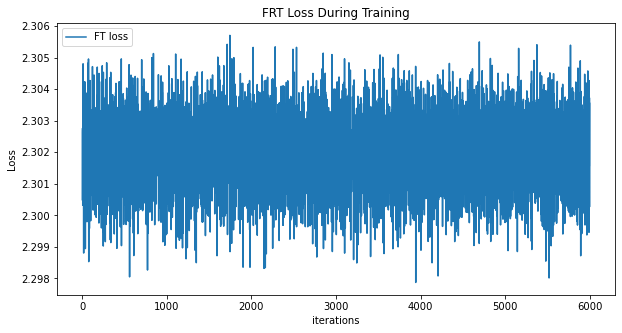

In [17]:
model_ft, FT_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=500)
plt.figure(figsize=(10,5))
plt.title("FRT Loss During Training")
plt.plot(FT_losses, label="FT loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [21]:
img=Image.open(r'C:\Users\user\ML\Session-4\data\test_me\val\irrfan-khan\Irrfan_Khan8.jpg')
tensor = data_transforms['val'](img).unsqueeze(0)
print(tensor.shape)
model_ft(tensor).argmax().item()

torch.Size([1, 3, 160, 160])


3

In [19]:
traced_model=torch.jit.trace(model_ft.cpu(),torch.randn(10,3,160,160))
torch.jit.save(traced_model, r"C:\Users\user\ML\Session-4\MTCNN.pt")